In [186]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]=["Microsoft YaHei"] #设置字体(必须兼容中英文，否则负号会出现问题）
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

shap.initjs()
result =  pd.read_csv("result.csv")
result

,width,length,author,auc_city,atw_time,art_company,fin_price
0,149,39.0,0,0,1933.000000,0,23000
1,33,61.0,1,1,1958.827828,1,34500
2,135,39.0,2,1,1958.827828,2,6900
3,175,42.0,3,2,1958.827828,3,22400
4,137,68.0,4,3,1958.827828,4,16800
...,...,...,...,...,...,...,...
27124,69,43.0,1699,8,1958.827828,472,2300
27125,138,69.0,1576,8,1958.827828,472,1150
27126,68,68.0,1576,8,1958.827828,472,1150
27127,138,69.0,1576,8,1958.827828,472,3450


In [187]:
y = result["fin_price"]
x = result.rename(columns={"width":"宽度","length":"长度","author":"作者","auc_city":"拍卖城市","atw_time":"拍卖时间","art_company":"拍卖公司"}).drop("fin_price",axis=1)
x

,宽度,长度,作者,拍卖城市,拍卖时间,拍卖公司
0,149,39.0,0,0,1933.000000,0
1,33,61.0,1,1,1958.827828,1
2,135,39.0,2,1,1958.827828,2
3,175,42.0,3,2,1958.827828,3
4,137,68.0,4,3,1958.827828,4
...,...,...,...,...,...,...
27124,69,43.0,1699,8,1958.827828,472
27125,138,69.0,1576,8,1958.827828,472
27126,68,68.0,1576,8,1958.827828,472
27127,138,69.0,1576,8,1958.827828,472


In [188]:
y

0        23000
1        34500
2         6900
3        22400
4        16800
         ...  
27124     2300
27125     1150
27126     1150
27127     3450
27128    17250
Name: fin_price, Length: 27129, dtype: int64

In [189]:
import shap
import xgboost

model = xgboost.XGBRegressor(n_estimator=1)
model.fit(x, y)
model

[12:30:42] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimator=1, n_estimators=100, n_jobs=16, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [190]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)
shap_values

array([[  279.60196 , -1287.8513  ,   195.63474 ,   282.58575 ,
         3549.2131  , -2540.8718  ],
       [  103.8788  ,  3076.9583  ,  1776.1906  ,  5090.5415  ,
        -1562.117   , -3077.1277  ],
       [  -20.327919, -2455.6301  , -1736.9965  ,  2725.833   ,
        -1144.4875  ,   241.68228 ],
       ...,
       [-3389.6567  ,   269.76193 , -3281.2947  ,  -704.65643 ,
         -593.10376 , -7173.9844  ],
       [ 1670.4962  ,  -383.90833 , -6150.7104  ,  -464.06332 ,
         -824.28973 , -6781.581   ],
       [  -34.96284 ,  -968.671   ,  1225.882   , -1812.2648  ,
        -1127.1176  ,  -357.2983  ]], dtype=float32)

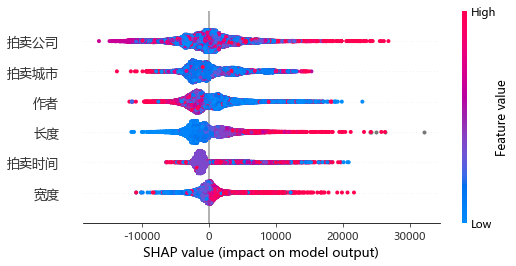

In [191]:
shap.summary_plot(shap_values, x)

In [192]:
x.iloc[0:1,]

,宽度,长度,作者,拍卖城市,拍卖时间,拍卖公司
0,149,39.0,0,0,1933.0,0


In [193]:
shap_value = explainer(x.iloc[0:1,])
shap_value

.values =
array([[  279.60196, -1287.8513 ,   195.63474,   282.58575,  3549.2131 ,
        -2540.8718 ]], dtype=float32)

.base_values =
array([21218.508], dtype=float32)

.data =
array([[ 149.,   39.,    0.,    0., 1933.,    0.]])

In [194]:
type(shap_value[0])

shap._explanation.Explanation

In [195]:
#定制类以修改显示出来的特征名
class MyExplanation(shap._explanation.Explanation):
   def __init__(self,shape_value,column_names):
      super(MyExplanation,self).__init__(shape_value)
      self.values = shape_value.values
      self.base_values = shape_value.base_values
      self.feature_names = shape_value.feature_names
      self.data = []
      data = list(shap_value.data[0])
      #遍历特征名
      for i,feature_name in enumerate(self.feature_names):
         self.data.append(data[i])
         #如果特征名在需要修改
         if feature_name in column_names:
            self.data[i] = column_names[feature_name]
      #原始data为[[]]类型
      self.data = [self.data]

my_shap_value = MyExplanation(shap_value,{"作者":"佚名","拍卖城市":"北京","拍卖公司":"保利"})
my_shap_value

.values =
array([[  279.60196, -1287.8513 ,   195.63474,   282.58575,  3549.2131 ,
        -2540.8718 ]], dtype=float32)

.base_values =
array([21218.508], dtype=float32)

.data =
[[149.0, 39.0, '佚名', '北京', 1933.0, '保利']]

In [196]:
shap_value.feature_names,shap_value.data

(['宽度', '长度', '作者', '拍卖城市', '拍卖时间', '拍卖公司'],
 array([[ 149.,   39.,    0.,    0., 1933.,    0.]]))

In [197]:
my_shap_value.feature_names

['宽度', '长度', '作者', '拍卖城市', '拍卖时间', '拍卖公司']

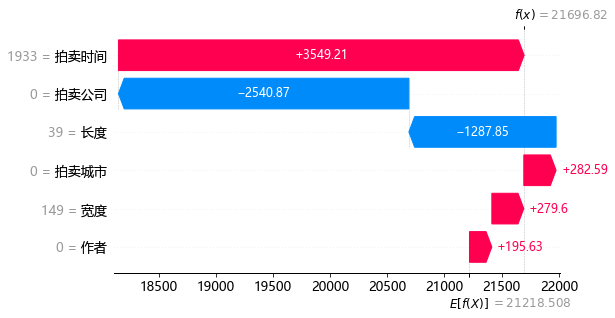

In [198]:
shap.waterfall_plot(shap_value[0])

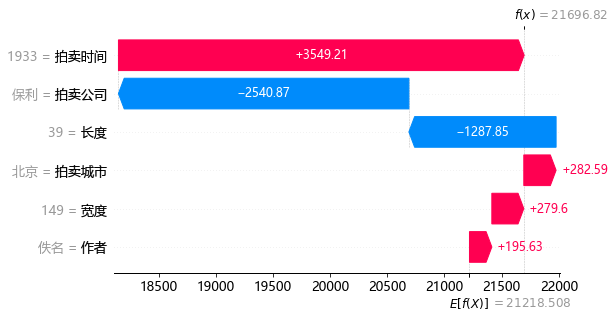

In [199]:
shap.waterfall_plot(my_shap_value[0])

In [200]:
shap.force_plot(explainer.expected_value, shap_values[0:1,:], x.iloc[0:1,:])

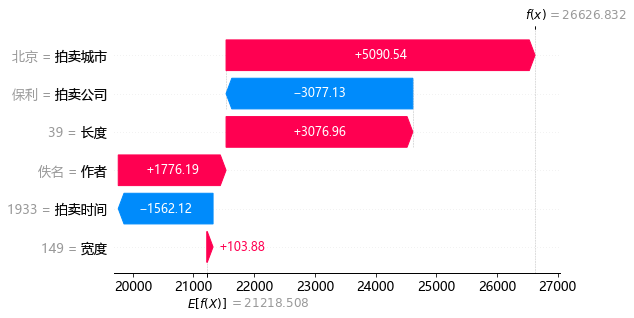

In [201]:
def getExplainer(row):
   shap_value = explainer(row)
   my_shape_value = MyExplanation(shap_value,{"作者":"佚名","拍卖城市":"北京","拍卖公司":"保利"})
   shap.waterfall_plot(my_shape_value[0],show=False)
   plt.savefig("waterflow.png",dpi=500)

getExplainer(x.iloc[1:2,])